In [1]:
#import matplotlib.pyplot as plt
import pyamg
import numpy as np
import scipy.sparse as sparse

import matplotlib.patches as mpatches
#from matplotlib.collections import PatchCollection

from matplotlib import rcParams, rc
import matplotlib.pylab as plt

fp = {'size': 32, 'family': 'serif', 'serif': ['Computer Modern']}
rc('font', **fp)
rc('text', usetex=True)

np.set_printoptions(precision=2)

%matplotlib inline

# Set up plotting functions

In [2]:
def outputcoordinates(x, y, scale=1):
    """dump into own pgf coordinates"""
    str = ""
    for xx, yy in zip(x, y):
        str += "\t(%f, %f)\n" % (xx / scale, yy / scale)
    return str

In [3]:
kwargs = {'clip_on': False, 'lw': 3, 'markersize': 10}

def plotaggs(x, AggOp, pad=0.04, withy=True, **kwargs):
    if not isinstance(AggOp, np.ndarray):
        AggOp = AggOp.toarray()
    for i in range(AggOp.shape[1]):
        J = np.where(AggOp[:,i]>0)[0]
        plt.plot(x[J], 0*x[J], 'ko', **kwargs, clip_on=False)
        
        h = x[1] - x[0]
        width = x[J].max() - x[J].min() + h - 2 * pad
        #rectangle = plt.Rectangle((x[J].min()-h/2+pad, -0.05), width, 0.1, fc='r')
        fancybox = mpatches.FancyBboxPatch((x[J].min()-h/2+pad, -0.03), width, 0.06,
                                           boxstyle=mpatches.BoxStyle("Round", pad=0.03),
                                           fc = (0.9, 0.9, 0.9),
                                           ec = (0.1, 0.1, 0.1),
                                          clip_on=False)
        plt.gca().add_patch(fancybox)
    
    plt.xlim((0,1))
    plt.gca().set_xticks([0.0, 1.0])
    if withy:
        #plt.ylim((0,1))
        #plt.gca().set_yticks([0, 1.0])
        plt.gca().autoscale_view('tight')
        plt.gca().tick_params(axis='y', direction='out')
        plt.gca().spines['left'].set_position(('outward', 10))
    else:
        plt.gca().spines['left'].set_color('none')
        plt.gca().yaxis.set_ticks([])
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
    plt.gca().spines['bottom'].set_position(('outward', 20))
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.gca().tick_params(axis='x', direction='out')
    plt.gca().tick_params(right='off')
    
    for label in plt.gca().get_xticklabels():
        label.set_fontname('Computer Modern')
        label.set_fontsize(24)
        
    if withy:
        for label in plt.gca().get_yticklabels():
            label.set_fontname('Computer Modern')
            label.set_fontsize(24)
            
def plotBerr(errs, labels, markers, **kwargs):
    for err, lab, mark in zip(errs, labels, markers):
        plt.plot(x, np.abs(err), mark, color='k', label=lab, **kwargs)
    
    plt.gca().set_yscale('log')
    plt.legend(frameon=False, loc=(0.8, 0.5), numpoints=1, fontsize=32, handlelength=0.0)
    plt.xlim((0,1))
    plt.gca().set_xticks([0.0, 1.0])
    plt.gca().tick_params(axis='y', direction='out')
    plt.gca().spines['left'].set_position(('outward', 10))
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
    plt.gca().spines['bottom'].set_position(('outward', 20))
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.gca().tick_params(axis='x', direction='out')
    plt.gca().tick_params(right='off')
    
    for label in plt.gca().get_xticklabels():
        label.set_fontname('Computer Modern')
        label.set_fontsize(24)
        
    for label in plt.gca().get_yticklabels():
        label.set_fontname('Computer Modern')
        label.set_fontsize(24)

In [4]:
def checkP(P, B):
    """Orthogonal projection of B onto the range of P"""
    Q = P.dot(np.linalg.pinv(P))
    
    error = Q.dot(B) - B
    return error

# problem setup

In [5]:
x = np.linspace(0,1,11)
x = x[1:-1]
A = pyamg.gallery.poisson((9,), format='csr')

In [6]:
Agg0 = np.zeros((9,3))
Agg0[[0,1,2],0] = 1
Agg0[[3,4,5],1] = 1
Agg0[[6,7,8],2] = 1
Agg0 = sparse.csr_matrix(Agg0)
AggOp = ('predefined', {'AggOp' : Agg0})
mlSA = pyamg.smoothed_aggregation_solver(A, max_coarse=1,
                                         smooth=('jacobi', {'omega': 4.0/3.0}),
                                         aggregate=AggOp,
                                         improve_candidates=None,
                                         keep=True)
print(mlSA.levels[0].T.toarray())

[[ 0.58  0.    0.  ]
 [ 0.58  0.    0.  ]
 [ 0.58  0.    0.  ]
 [ 0.    0.58  0.  ]
 [ 0.    0.58  0.  ]
 [ 0.    0.58  0.  ]
 [ 0.    0.    0.58]
 [ 0.    0.    0.58]
 [ 0.    0.    0.58]]


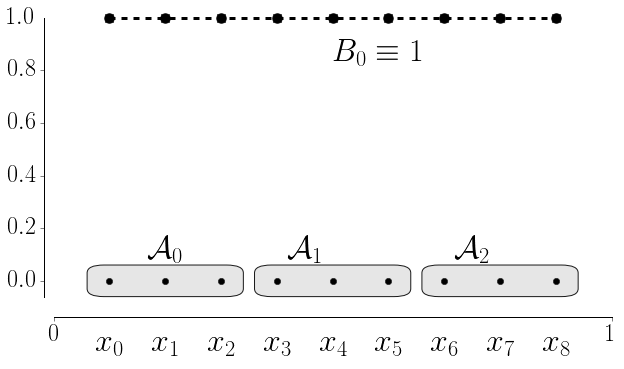

In [7]:
plt.figure(figsize=(10,5))
plotaggs(x, mlSA.levels[0].AggOp)
plt.plot(x, 1.0+0*x, 'ko--', **kwargs)
plt.text(0.5, 0.9, r'$B_{0} \equiv 1$', fontsize=32, va='top')
plt.text((x[1]+x[0])/2+0.05, 0.07, r'$\mathcal{A}_0$', ha='center', fontsize=32)
plt.text((x[4]+x[3])/2, 0.07, r'$\mathcal{A}_1$', ha='center', fontsize=32)
plt.text((x[7]+x[6])/2, 0.07, r'$\mathcal{A}_2$', ha='center', fontsize=32)
for i in range(len(x)):
    plt.text(x[i], -0.2, r'$x_{%d}$'%i, ha='center', fontsize=32, va='top')

# 1 candidate, CSR

Standard SA

Plot the columns of $T$ and $P$.  Then plot the error in $B$.

SA Berr:
[[  2.22e-16]
 [  2.22e-16]
 [  2.22e-16]
 [  2.22e-16]
 [  2.22e-16]
 [  2.22e-16]
 [  2.22e-16]
 [  2.22e-16]
 [  2.22e-16]]
SA P:
[[ 0.32  0.    0.  ]
 [ 0.44  0.07  0.  ]
 [ 0.39  0.19  0.  ]
 [ 0.19  0.39  0.  ]
 [ 0.07  0.44  0.07]
 [ 0.    0.39  0.19]
 [ 0.    0.19  0.39]
 [ 0.    0.07  0.44]
 [ 0.    0.    0.32]]


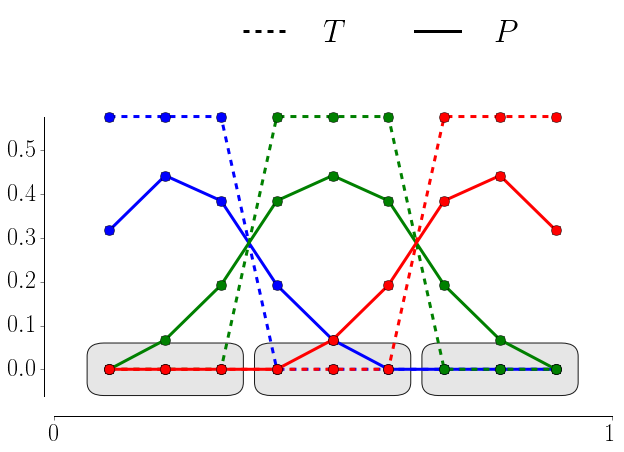

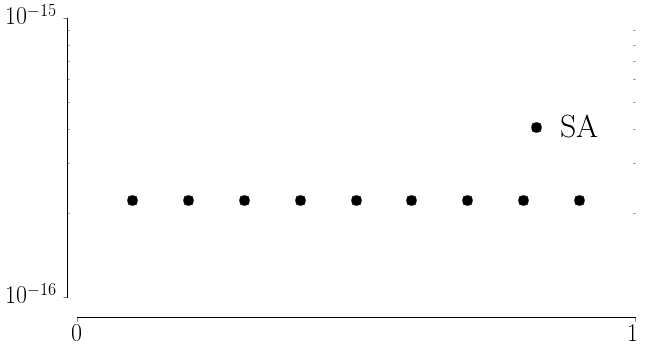

In [10]:
B = np.ones((A.shape[0],1))
mlSA = pyamg.smoothed_aggregation_solver(A, B=B,
                                         aggregate=AggOp,
                                         max_coarse=1, smooth=('jacobi', {'omega': 4.0/3.0, 'degree': 2}), 
                                         keep=True, improve_candidates=None)

T = mlSA.levels[0].T.toarray()
P = mlSA.levels[0].P.toarray()
TSA = T
plt.figure(figsize=(10,5))
plotaggs(x, mlSA.levels[0].AggOp)
colors = ['b', 'g', 'r']
for i in range(3):
    c = colors[i]
    J = np.where(T[:, i])[0].ravel()
    xx = x#[J]
    yy = T[:,i]#[J,i].ravel()
    plt.plot(xx, yy, '--o', color=c, **kwargs)
    J = np.where(P[:, i])[0].ravel()
    xx = x#[J]
    yy = P[:,i]#[J,i]
    plt.plot(xx, yy, '-o', color=c, **kwargs)
    
#Create custom artists
simT = plt.Line2D((0,0),(0,0), color='k', linestyle='--', **kwargs)
simP = plt.Line2D((0,0),(0,0), color='k', linestyle='-', **kwargs)

#Create legend from custom artist/label lists
plt.gca().legend([simT, simP],['$T$', '$P$'], fontsize=32, ncol=2, frameon=False, loc=(0.3, 1.2))

SABerr = checkP(T, B)
print("SA Berr:")
print(SABerr)

print("SA P:")
print(mlSA.levels[0].P.toarray())

plt.figure(figsize=(10,5))
plotBerr([SABerr], ['SA'], ['o'], **kwargs)